In [38]:
%run SketchFunctions.py

SKetcH2


---

## Setting up for Simulation

### Simulation Parameters

* `N`: observations
* `D`: parameters
* `gamma`: sketch Compression Level
* `link`: GLM Link function, currently supports 'linear' and 'logistic'
* `beta_true`: Randomly generate true coefficients
* `dataX, dataY`: randomly generated data for regression modeling
* `beta_hat`: Estimate from full GLM fit

In [ ]:
N = 2**10
D = 100
gamma = 4
link = "linear"
beta_true = np.random.uniform(-2, 2, D).reshape(D, 1)
dataX, dataY = generateData(N, beta_true, link=link, sigma=1.0)
beta_hat = lm(dataX, dataY)

### TensorFlow Placeholders

In [ ]:
# placeholding tensors and variable
X = tf.placeholder('float', [None, D]) 
Y = tf.placeholder('float', [None, 1])
beta = tf.Variable(tf.random_normal([D, 1], stddev=1.0))

In [ ]:
if link == 'linear':
    # linear regression with mean squared error
    Y_hat = tf.matmul(X, beta)
    loss = tf.reduce_sum(tf.square(Y - Y_hat))
elif link == 'logistic':
    # logistic regression with log loss
    eta = tf.matmul(X, beta)
    p = 1.0 / (1.0 + tf.exp(-eta))
    loss = -1.0 * (tf.reduce_sum(Y * tf.log(p) + (1.0 - Y) * tf.log(1 - p)))    

### TensorFlow Loss, Grad, Hess

In [ ]:
# Gradient of loss function
grad = tf.gradients(loss, beta)

In [ ]:
# Hessian and Fisher Information
hessian = compute_hessian()
fisher = tf.matrix_inverse(hessian)

In [ ]:
# TensorFlow code to Update beta by delta
delta = tf.placeholder('float', [D, 1])
update = beta.assign_add(delta)

### Set up Stopping Criteria, Note-taking Variables

In [ ]:
# Simulation Parameters
MAXITER = 50
TOL = 10**(-12)

# For Recording Sample Path
path = np.zeros((MAXITER, D + 1))


---

## Example Simulation

##### The following cell gives an example of running a Iterated Hessian Sketch simulation.

##### Here are a few notes on the implementation of IHS given here.  Fuller details are discussed in the accompanying write-up.

- At each iteration of the Newton-Raphson algorithm, a random projection is applied to the sample data.  The gradient and Hessian are then computed on this sketched data and the coefficient vector estimate is updated following the usual Newton-Raphson procedure.<br><br>

- A crude half-stepping procedure is used here to help ensure that the loss function is decreasing steadily.<br><br>
    
* The `stepsize` is reset to 1 at each iteration to encourage larger steps (relative to the grad-FisherInfo).  More intelligent step-sizing can likely be used to increase convergence in practical settings.<br><br>
    
* The algorithm will run for the fixed number of iterations given by `MAXITER`, but convergence to an acceptable tolerance may occur sooner.  Theoretical results (Pilanci 2015) give formulas to calculate or approximate the needed number of iterations to achieve a desired error tolerance. <br><br>
    
* This code fits the regression model with the Newton-Raphson method, applying a sketching matrix to _both_ the gradient and the Hessian.<br><br>

* __N.B.__ This actually differs from the method given in the Pilanci & Wainwright 2015 description, where the sketching is applied only to the Hessian matrix.  While their derived theoretical bounds apply specifically to the case of sketching only on the Hessian, we have found that sketching on the gradient actually seems to improve performance in this simple setting.  It is not clear if sketching on the gradient as well will maintain accuracy and computational gains in more complicated settings.<br><br>

##### Important Simulation settings used are:

* Gaussian sketching
* `N = 1024`
* `D = 100`
* `gamma = 4` compression, for sketch dimension of `R = gamma * D = 400`
* `MAXITER = 50`
* `X` ~ Normal(0, 1) [i.i.d.]
* `Y` data generated from Normal OLS model with linear link [i.i.d.]
* True beta coefficients ~ Uniform(-2, 2) [i.i.d.]
* Initial beta estimates drawn from random Normal(0, 1)

In [ ]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    stepsize = 1.0
    for i in range(MAXITER):
        if i % 10 == 0:
            print(i//10 + 1, end='')
            
        # Sketching with chosen method and compression factor
        sketchX, sketchY = sketch(dataX, dataY, gamma, method='gaussian')
        
        # Compute Gradient
        g = sess.run(grad, feed_dict={X: sketchX, Y: sketchY})[0]
        
        # Compute Fisher Info
        I = sess.run(fisher, feed_dict={X: sketchX, Y: sketchY})
        
        # Take Newton-Raphson Step
        stepsize = 1.0
        current_loss = sess.run(loss, feed_dict={X: dataX, Y: dataY})
        sess.run(update, feed_dict={delta : -np.dot(I, g) * stepsize})
        new_loss = sess.run(loss, feed_dict={X: dataX, Y: dataY})
        
        # Backstepping to ensure decrease in loss function
        while (new_loss > current_loss) and (stepsize > TOL):
            stepsize = stepsize / 2.0
            sess.run(update, feed_dict={delta : np.dot(I, g) * stepsize})
            new_loss = sess.run(loss, feed_dict={X: dataX, Y: dataY})
        stepsize = min(1.0, 2 * stepsize)
        
        # Note step and new error ratio
        path[i, :-1] = np.transpose(beta.eval())
        path[i, -1] = get_ratio(path[i, :-1], beta_true)

### Run Simulation

###### The `simulate()` function below is a wrapper for the entire simulation process outlined above.  Full code and supporting documentation are provided in the SketchFunctions.py file.

###### The following cell runs the simulation and provides the error output.  The path of optimization path of beta parameters and error ratios are returned by the function later use.

In [42]:
path = simulate(2**10, 100, gamma=4, MAXITER=50)

*********************************

Beginning IHS Simulation
-----------------------------

    N =  1024
    D =  100
    link =  linear
    gamma =  4
    method =  gaussian
------------------------------

Iterate: 
1.2.3.4.5.
------------------------------

Error Ratio:  0.000100188474248 

*** Simulation Complete ***


### Plotting Results

50


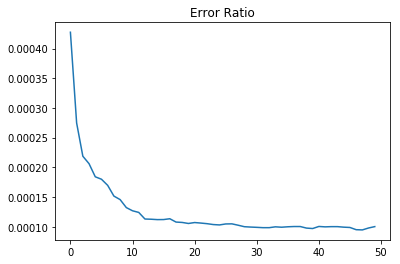

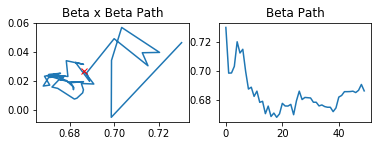

In [54]:
plot_path(path, coeff_ind = [1, 2])

---

## Logistic Regression

In [ ]:
N = 2**10
D = 10
gamma = 50
link = "logistic"
beta_true = np.random.uniform(-2, 2, D).reshape(D, 1)

In [57]:
path = simulate(2**10, 5, link="logistic")

*********************************

Beginning IHS Simulation
-----------------------------

    N =  1024
    D =  5
    link =  logistic
    gamma =  4
    method =  gaussian
------------------------------

here
Iterate: 
1.

InvalidArgumentError: Input is not invertible.
	 [[Node: MatrixInverse_20 = MatrixInverse[T=DT_FLOAT, adjoint=false, _device="/job:localhost/replica:0/task:0/cpu:0"](concat_813)]]

Caused by op 'MatrixInverse_20', defined at:
  File "/home/dustin/.conda/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-57-bd8c357d5a80>", line 1, in <module>
    path = simulate(2**10, 5, link="logistic")
  File "/home/dustin/Dropbox/Coursework/Winter2017/STAT230/Project/sketching-master/SketchFunctions.py", line 178, in simulate
    fisher = tf.matrix_inverse(hessian)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 330, in matrix_inverse
    name=name)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/dustin/.conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Input is not invertible.
	 [[Node: MatrixInverse_20 = MatrixInverse[T=DT_FLOAT, adjoint=false, _device="/job:localhost/replica:0/task:0/cpu:0"](concat_813)]]
